In [5]:
import numpy as np
import matplotlib.pyplot as plt

import os

from gendata_2dt import *
from encoding_matrix import gen_encoding
from womm_phantom import gen_phantom_parts
from c_velsolve import *

%matplotlib inline

### Generate Encoding Matrix

In [6]:
venc = 50
A0 = gen_encoding('6pt-Zwart', True)
A = A0 * np.pi / venc

print(A)

[[ 0.          0.          0.        ]
 [ 0.          0.03303266  0.05344797]
 [ 0.03303266  0.05344797  0.        ]
 [ 0.05344797  0.          0.03303266]
 [ 0.         -0.03303266  0.05344797]
 [-0.03303266  0.05344797  0.        ]
 [-0.05344797  0.          0.03303266]]


### Simulate velocities
The noiseless simulation is saved on disk so repeat experiments go faster

In [9]:
sim_res = 0.2 # Resolution (mm) of high res phantom

fname = 'icosa6_venc%.0f_sres%.2f.npz' % (venc, sim_res)

if not os.path.isfile(fname):   
    sim_res, v3, k_v3, k_mask, k_data = precompute_2dt(A, oversamp = 2, s_res = sim_res*2, diam=(5,7.5,10,12.5), signal = (.8, 1.0))
    np.savez_compressed(fname, sim_res = sim_res, v3 = v3, k_v3 = k_v3, k_mask = k_mask, k_data=k_data)

### Simulate acquisition data
High resolution simulated dat is subsampled, noise is added, and converted to complex data based on the encoding matrix

v3ss is the noiseless reference velocity at a matched resolution, mask_ss is an aray of vessel masks, data_ss is the simulated data

(-0.5, 33.5, 95.5, -0.5)

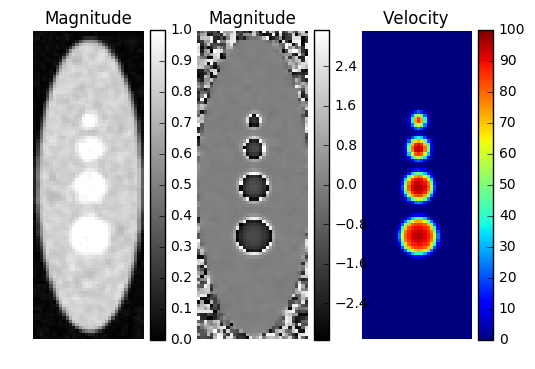

In [29]:
SNR = 30
res = 1.0

v3ss, mask_ss, data_ss = subsample_precomputed_2dt(fname, s_res = res, SNR = SNR)
mag = np.abs(data_ss[0])
data_ss = data_ss[1:] * np.exp(-1j * np.angle(data_ss[0]))

# Display Magnitude and Velocity
f, (ax1, ax2, ax3) = plt.subplots(1, 3)

im = ax1.imshow(np.abs(mag[5]), cmap='gray', clim=(0,1), interpolation='nearest')
f.colorbar(im, ax=ax1)
ax1.set_title('Magnitude')
ax1.axis('off')

im = ax2.imshow(np.angle(data_ss[0,5]), cmap='gray', interpolation='nearest')
f.colorbar(im, ax=ax2)
ax2.set_title('Magnitude')
ax2.axis('off')

im = ax3.imshow(v3ss[2,5], clim=(0,100), interpolation='nearest')
f.colorbar(im, ax=ax3)
ax3.set_title('Velocity')
ax3.axis('off')

wraps = [ 1.  1.  1.  1.  1.  1.]
v_solve took total = 2.407875 and the cpp part took 2.401221
norms = [ 1.  1.  1.  1.  1.  1.]


(-0.5, 33.5, 95.5, -0.5)

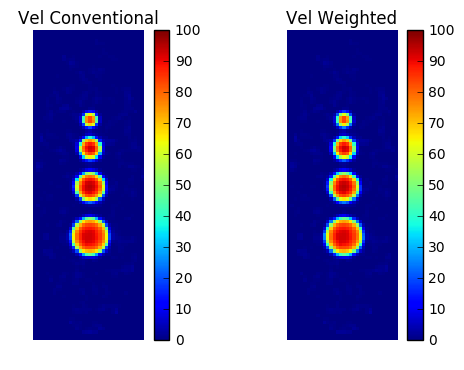

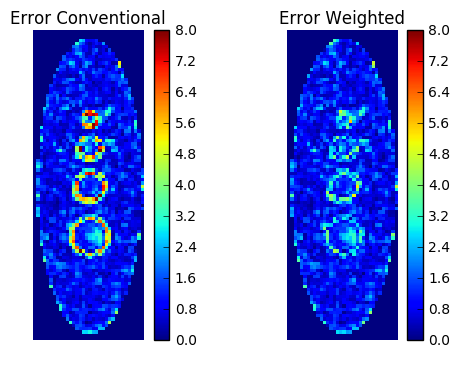

In [39]:
# Mask out air voxels
compute_mask = np.zeros(data_ss.shape[1:], np.int16)
compute_mask[1:9, mag[0]>0.3] = 1

# Conventional Solver
v_out = c_vel_solve(data_ss, A[1:], 100.0, mask=compute_mask)
err0 = v_out - v3ss[np.newaxis,...]
tot_err0 = np.sqrt((err0**2.0).sum(1)).mean(0)

# Weighted NC solver
v_out_w = c_vel_solve_weighted(data_ss, A[1:], 100.0, wnorm=2.0, mask=compute_mask)
err1 = v_out_w - v3ss[np.newaxis,...]
tot_err1 = np.sqrt((err1**2.0).sum(1)).mean(0)


# Display Recons
f, (ax1, ax2) = plt.subplots(1, 2)

im = ax1.imshow(v_out[2,5], clim=(0,100), interpolation='nearest')
f.colorbar(im, ax=ax1)
ax1.set_title('Vel Conventional')
ax1.axis('off')

im = ax2.imshow(v_out_w[2,5], clim=(0,100), interpolation='nearest')
f.colorbar(im, ax=ax2)
ax2.set_title('Vel Weighted')
ax2.axis('off')

# Display Error
f, (ax1, ax2) = plt.subplots(1, 2)

im = ax1.imshow(tot_err0[5], clim=(0,8), interpolation='nearest')
f.colorbar(im, ax=ax1)
ax1.set_title('Error Conventional')
ax1.axis('off')

im = ax2.imshow(tot_err1[5],  clim=(0,8), interpolation='nearest')
f.colorbar(im, ax=ax2)
ax2.set_title('Error Weighted')
ax2.axis('off')